# MLP

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from itertools import chain

## Definicja klasy MLP

In [2]:
class MLP:
    def __init__(self, layers, activation, activation_derivative):
        self.layers = layers
        self.activation = activation
        self.activation_derivative = activation_derivative
        weights = []
        for i in range(len(self.layers[:-1])):
            weights.append([np.random.uniform(0, 1, (self.layers[i+1], self.layers[i])),
                            np.random.uniform(0, 1, (self.layers[i+1], 1))])
        self.weights = weights
        self.weights_norms = []
        self.biases_norms = []
        
    def forward(self, X):
        self.inputs = []
        Z = X.T
        self.inputs.append(Z)

        i = 1
        for weights, biases in self.weights:
            Z = np.dot(weights, Z) + biases
            self.inputs.append(Z)
            if i != len(self.weights):
                Z = self.activation(Z)
            i += 1
        
        return Z.T
    
    def backward(self, y, learning_rate, batch_size):
        
        dws = []
        dbs = []
        
        y_pred = self.inputs[-1]
        self.inputs = self.inputs[:-1]
        dA = y_pred - y
             
        for i in range(1, len(self.inputs)+1):
            
            Z = self.inputs[-i]
            A = self.activation(Z)
            
            dw = -learning_rate * np.dot(dA, A.T)/batch_size
            db = -learning_rate * np.sum(dA, axis=1, keepdims=True)/batch_size
            
            dws.append(dw)
            dbs.append(db)
            
            W = self.weights[-i][0]
            dA = np.dot(W.T, dA) * self.activation_derivative(Z)

        for i in range(len(self.weights)):
            self.weights[i][0] += dws[-i-1]
            self.weights[i][1] += dbs[-i-1] 
        
        self.weights_norms.append([np.linalg.norm(w) for w in [self.weights[l][0] for l in range(len(self.layers)-1)]])
        self.biases_norms.append([np.linalg.norm(b) for b in [self.weights[l][1] for l in range(len(self.layers)-1)]])
            
    def train(self, x_train, y_train, x_test, y_test, epochs, learning_rate, batch_size=None):
        if batch_size == None:
            batch_size = len(x_train)
            
        mse_train = []
        mse_test = []
        
        for i in range(epochs):
            p = np.random.permutation(len(x_train))
            xp = x_train[p]
            yp = y_train[p]
            
            for x_batch,y_batch in zip(self.create_batches(xp, batch_size), self.create_batches(yp, batch_size)):
                self.predict(x_batch)
                self.backward(y_batch.T, learning_rate, batch_size)
        
            y_train_pred = self.predict(x_train)
            mse_train.append(mse(y_train_pred, y_train))
            y_pred = self.predict(x_test)
            mse_test.append(mse(y_pred, y_test))
        
        return mse_train, mse_test
    
    def create_batches(self, perm, n=1):
        for ind in range(0, len(perm), n):
            yield perm[ind:min(ind + n, len(perm))]
            
    def predict(self, x):
        return self.forward(x)
        
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

## Zbiór square-simple

In [3]:
df_train = pd.read_csv('mio1/regression/square-simple-training.csv', index_col=0)
x_train, y_train = np.array(df_train['x']).reshape(-1,1), np.array(df_train['y']).reshape(-1,1)

df_test = pd.read_csv('mio1/regression/square-simple-test.csv', index_col=0)
x_test, y_test = np.array(df_test['x']).reshape(-1,1), np.array(df_test['y']).reshape(-1,1)

#### Wizualizacja zbioru

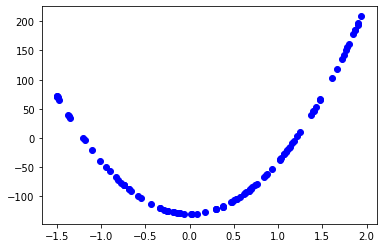

In [4]:
plt.plot(x_train, y_train, 'bo')

#### Treinng sieci

In [5]:
np.random.seed(9)
mlp = MLP([1,10,10,1], sigmoid, sigmoid_derivative)

Wersja z podziałem na batche (do momentu MSE<4):

In [6]:
mse_train_list=[]
mse_test_list=[]

last_mse_test = np.inf

i=1
while last_mse_test>4:
    print(i)
    i+=1
    mse_train, mse_test = mlp.train(x_train, y_train, x_test, y_test, 1000, 0.0005, 10)
    print('Train MSE: ', mse_train[-1])
    print('Test MSE: ', mse_test[-1])
    mse_train_list.append(mse_train)
    mse_test_list.append(mse_test)
    last_mse_test=mse_test[-1]

1
Train MSE:  9172.764941305266
Test MSE:  7310.076040497877
2
Train MSE:  8788.580504214016
Test MSE:  7048.5494722749445
3
Train MSE:  8568.590153459196
Test MSE:  6931.823446844101
4
Train MSE:  8489.549043267818
Test MSE:  6919.297911563502
5
Train MSE:  2635.176091865187
Test MSE:  2001.9723004494806
6
Train MSE:  609.6839980880993
Test MSE:  481.6167626089227
7
Train MSE:  42.561310587869784
Test MSE:  46.050909856858695
8
Train MSE:  16.53475785741827
Test MSE:  24.791404845014025
9
Train MSE:  8.617134607032623
Test MSE:  15.372688288586446
10
Train MSE:  4.579871134832202
Test MSE:  9.874986577491393
11
Train MSE:  15.571760394653854
Test MSE:  16.85220365697767
12
Train MSE:  4.079573057569978
Test MSE:  8.113146792336579
13
Train MSE:  3.4398570924688845
Test MSE:  5.6945110454191425
14
Train MSE:  2.221895185127262
Test MSE:  5.456047804733192
15
Train MSE:  1.4204873423971593
Test MSE:  4.263365770847859
16
Train MSE:  1.1997692432102007
Test MSE:  3.572485105286146


Dopasowanie predykcji do zbioru testowego:

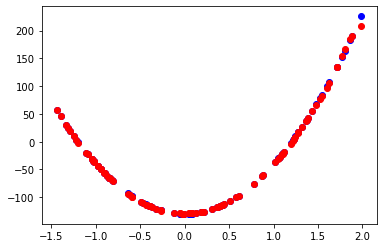

In [7]:
y_pred = mlp.predict(x_test)
plt.plot(x_test, y_test, 'bo')
plt.plot(x_test, y_pred, 'ro')

Wizualizacja zmiany wag:

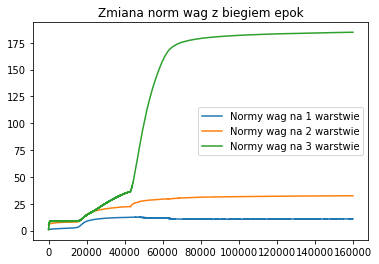

In [8]:
x = [i for i in range(1, 16*1000*10)]
w1 = [mlp.weights_norms[i][0] for i in range(len(x))]
w2 = [mlp.weights_norms[i][1] for i in range(len(x))]
w3 = [mlp.weights_norms[i][2] for i in range(len(x))]

fig, ax = plt.subplots()

ax.plot(x,w1, label='Normy wag na 1 warstwie')
ax.plot(x,w2, label='Normy wag na 2 warstwie')
ax.plot(x,w3, label='Normy wag na 3 warstwie')

ax.set_title('Zmiana norm wag z biegiem epok')
ax.legend()
plt.show()

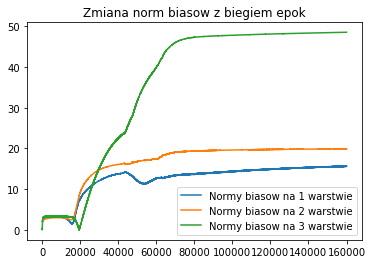

In [9]:
x = [i for i in range(1, 16*1000*10)]
b1 = [mlp.biases_norms[i][0] for i in range(len(x))]
b2 = [mlp.biases_norms[i][1] for i in range(len(x))]
b3 = [mlp.biases_norms[i][2] for i in range(len(x))]

fig, ax = plt.subplots()

ax.plot(x,b1, label='Normy biasow na 1 warstwie')
ax.plot(x,b2, label='Normy biasow na 2 warstwie')
ax.plot(x,b3, label='Normy biasow na 3 warstwie')

ax.set_title('Zmiana norm biasow z biegiem epok')
ax.legend()
plt.show()

Wersja bez podziału na batche, wykonamy tyle samo iteracji, ile zajęło zejście do MSE < 4 trenując z batchami i porównamy uzyskane MSE, aby określić, która wersja uczy się szybciej: 

In [10]:
np.random.seed(9)
mlp = MLP([1,10,10,1], sigmoid, sigmoid_derivative)

In [11]:
mse_train_list_nobatches=[]
mse_test_list_nobatches=[]

for i in range(16):
    print(i)
    mse_train, mse_test = mlp.train(x_train, y_train, x_test, y_test, 1000, 0.0005)
    print('Train MSE: ', mse_train[-1])
    print('Test MSE: ', mse_test[-1])
    mse_train_list_nobatches.append(mse_train)
    mse_test_list_nobatches.append(mse_test)

0
Train MSE:  9176.55729564039
Test MSE:  7316.673578747486
1
Train MSE:  9175.136876729926
Test MSE:  7312.446314112104
2
Train MSE:  9174.47765229439
Test MSE:  7311.6002254989035
3
Train MSE:  9174.085344191692
Test MSE:  7311.107597079152
4
Train MSE:  9173.812895021365
Test MSE:  7310.784860965171
5
Train MSE:  9173.598305959964
Test MSE:  7310.557018371315
6
Train MSE:  9173.408587385296
Test MSE:  7310.386443522148
7
Train MSE:  9173.2209607566
Test MSE:  7310.251781453804
8
Train MSE:  9173.013765495354
Test MSE:  7310.139191382305
9
Train MSE:  9172.75854459526
Test MSE:  7310.037798955243
10
Train MSE:  9172.406978348517
Test MSE:  7309.936086667241
11
Train MSE:  9171.858930634453
Test MSE:  7309.816337364062
12
Train MSE:  9170.862040356655
Test MSE:  7309.639330149912
13
Train MSE:  9168.604406772962
Test MSE:  7309.272270350513
14
Train MSE:  9161.542031497871
Test MSE:  7307.7107562551555
15
Train MSE:  9132.497754679602
Test MSE:  7294.442249646883


Możemy jeszcze porównać wyniki graficznie, analiza potwierdza szybsze uczenie przy implementacji batchów:

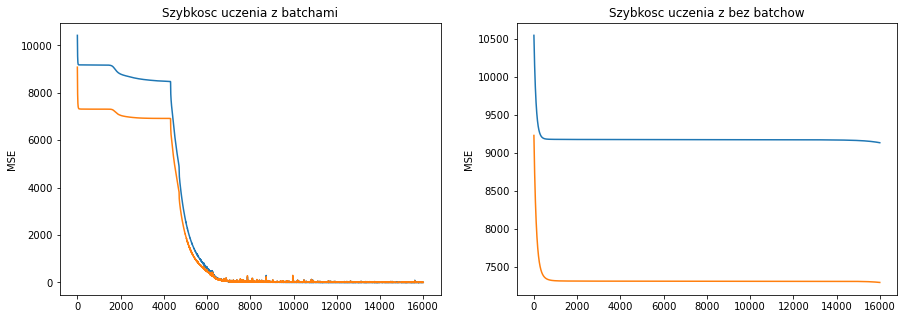

In [12]:
unnested_mse_train_list = list(chain.from_iterable(mse_train_list))
unnested_mse_test_list = list(chain.from_iterable(mse_test_list))
unnested_mse_train_list_nobatches = list(chain.from_iterable(mse_train_list_nobatches))
unnested_mse_test_list_nobatches = list(chain.from_iterable(mse_test_list_nobatches))


fig, axs = plt.subplots(1,2, figsize=(15, 5))

x1 = np.arange(0, len(unnested_mse_train_list))
axs[0].plot(x1, unnested_mse_train_list)
axs[0].plot(x1, unnested_mse_test_list)
axs[0].set_ylabel('MSE')
axs[0].set_title('Szybkosc uczenia z batchami')

x1 = np.arange(0, len(unnested_mse_train_list_nobatches))
axs[1].plot(x1, unnested_mse_train_list_nobatches)
axs[1].plot(x1, unnested_mse_test_list_nobatches)
axs[1].set_title('Szybkosc uczenia z bez batchow')
axs[1].set_ylabel('MSE')

plt.show()


## Zbiór steps-small

In [13]:
df_train = pd.read_csv('mio1/regression/steps-small-training.csv')
x_train, y_train = np.array(df_train['x']).reshape(-1,1), np.array(df_train['y']).reshape(-1,1)

df_test = pd.read_csv('mio1/regression/steps-small-test.csv')
x_test, y_test = np.array(df_test['x']).reshape(-1,1), np.array(df_test['y']).reshape(-1,1)

 #### Wizualizacja zbioru

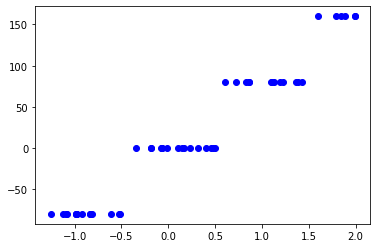

In [14]:
plt.plot(x_train, y_train, 'bo')

#### Trening sieci

Mimo licznych prób nie udało się osiągnąc zadanego poziomu MSE na zbiorze testowym, zadowolimy się więc MSE=2 na zbiorze treningowym. Problem ze zbiorem testowym wynika prawdopodobnie z nieścisłości ze zbiorem treningowym, przez co sieć nie jest w stanie przewidzieć wartości kilku obserwacji, utrzymując MSE na poziomie około 100.

In [15]:
np.random.seed(9)
mlp = MLP([1,10,10,1], sigmoid, sigmoid_derivative)

In [16]:
mse_train_list=[]
mse_test_list=[]

last_mse_train = np.inf

i=1
while last_mse_train>2:
    print(i)
    i+=1
    mse_train, mse_test = mlp.train(x_train, y_train, x_test, y_test, 1000, 0.0001, 10)
    print('Train MSE: ', mse_train[-1])
    print('Test MSE: ', mse_test[-1])
    mse_train_list.append(mse_train)
    mse_test_list.append(mse_test)
    last_mse_train=mse_train[-1]

1
Train MSE:  5982.994089098303
Test MSE:  7020.3464054235965
2
Train MSE:  2546.354857705007
Test MSE:  2910.3417931084514
3
Train MSE:  1936.5728061629923
Test MSE:  2211.2278634047307
4
Train MSE:  1603.3275558784867
Test MSE:  1801.5617935482762
5
Train MSE:  1351.975354560332
Test MSE:  1489.1295499548544
6
Train MSE:  1147.1230682514379
Test MSE:  1245.764147877312
7
Train MSE:  939.9082413928846
Test MSE:  1024.788441122064
8
Train MSE:  773.6760953968308
Test MSE:  851.1334630001076
9
Train MSE:  618.9395662366346
Test MSE:  706.7765482691331
10
Train MSE:  502.194049767202
Test MSE:  592.4997948188424
11
Train MSE:  417.33142121033035
Test MSE:  506.04384160311434
12
Train MSE:  352.72072722510995
Test MSE:  438.5673355914648
13
Train MSE:  299.9885436909887
Test MSE:  385.4761692200739
14
Train MSE:  240.7720538009683
Test MSE:  335.31511453934667
15
Train MSE:  192.36428107122555
Test MSE:  290.4120135514042
16
Train MSE:  156.77285268979568
Test MSE:  255.53146076623787
17


Train MSE:  2.042662890804531
Test MSE:  99.94667076050364
132
Train MSE:  2.0202492676303514
Test MSE:  99.89823160751148
133
Train MSE:  1.9982741841498952
Test MSE:  99.85119608692602


Dopasowanie predykcji do zbioru testowego:

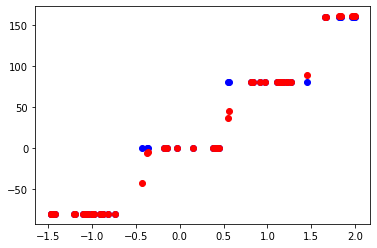

In [17]:
y_pred = mlp.predict(x_test)
plt.plot(x_test, y_test, 'bo')
plt.plot(x_test, y_pred, 'ro')

Wizualizacja zmiany wag

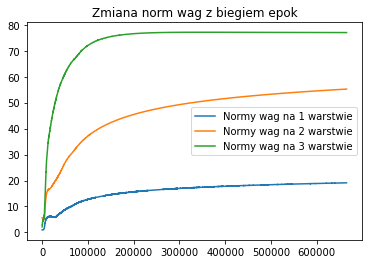

In [18]:
x = [i for i in range(1, 133*1000*5)]
w1 = [mlp.weights_norms[i][0] for i in range(len(x))]
w2 = [mlp.weights_norms[i][1] for i in range(len(x))]
w3 = [mlp.weights_norms[i][2] for i in range(len(x))]

fig, ax = plt.subplots()

ax.plot(x,w1, label='Normy wag na 1 warstwie')
ax.plot(x,w2, label='Normy wag na 2 warstwie')
ax.plot(x,w3, label='Normy wag na 3 warstwie')

ax.set_title('Zmiana norm wag z biegiem epok')
ax.legend()
plt.show()

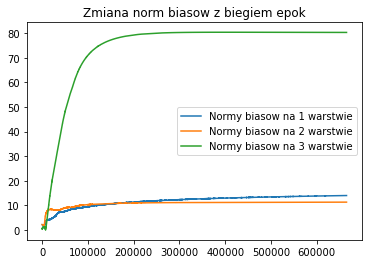

In [19]:
x = [i for i in range(1, 133*1000*5)]
b1 = [mlp.biases_norms[i][0] for i in range(len(x))]
b2 = [mlp.biases_norms[i][1] for i in range(len(x))]
b3 = [mlp.biases_norms[i][2] for i in range(len(x))]

fig, ax = plt.subplots()

ax.plot(x,b1, label='Normy biasow na 1 warstwie')
ax.plot(x,b2, label='Normy biasow na 2 warstwie')
ax.plot(x,b3, label='Normy biasow na 3 warstwie')

ax.set_title('Zmiana norm biasow z biegiem epok')
ax.legend()
plt.show()

Ponownie wykonamy tyle samo iteracji trenując bez podzaiłu na batche:

In [20]:
np.random.seed(9)
mlp = MLP([1,10,10,1], sigmoid, sigmoid_derivative)

In [21]:
mse_train_list_nobatches=[]
mse_test_list_nobatches=[]

for i in range(133):
    print(i)
    mse_train, mse_test = mlp.train(x_train, y_train, x_test, y_test, 1000, 0.0001)
    print('Train MSE: ', mse_train[-1])
    print('Test MSE: ', mse_test[-1])
    mse_train_list_nobatches.append(mse_train)
    mse_test_list_nobatches.append(mse_test)

0
Train MSE:  6394.209728404613
Test MSE:  7589.853264641202
1
Train MSE:  6373.796432857245
Test MSE:  7530.904921240861
2
Train MSE:  6346.582253927075
Test MSE:  7484.489358781935
3
Train MSE:  6273.809439938208
Test MSE:  7386.9066104270905
4
Train MSE:  5982.897489172969
Test MSE:  7020.208020223687
5
Train MSE:  5090.769505840051
Test MSE:  5944.792934154568
6
Train MSE:  3996.178822789035
Test MSE:  4639.663393168835
7
Train MSE:  3266.132217417684
Test MSE:  3764.460009087227
8
Train MSE:  2824.6683355507166
Test MSE:  3237.9801630118177
9
Train MSE:  2546.2700981266717
Test MSE:  2910.255753485757
10
Train MSE:  2357.33339769349
Test MSE:  2691.6958925438153
11
Train MSE:  2218.645120305441
Test MSE:  2533.764811434052
12
Train MSE:  2109.2907441951265
Test MSE:  2410.2003742598154
13
Train MSE:  2017.6659529715782
Test MSE:  2306.0853400425285
14
Train MSE:  1936.4562975161455
Test MSE:  2211.4133772995356
15
Train MSE:  1860.6917233952097
Test MSE:  2119.4782274112144
16
Tra

Train MSE:  39.50956667235876
Test MSE:  138.98006012389283
131
Train MSE:  38.736386025972166
Test MSE:  138.2279198656845
132
Train MSE:  37.985680106542866
Test MSE:  137.4977734217294


I porównanie graficzne:

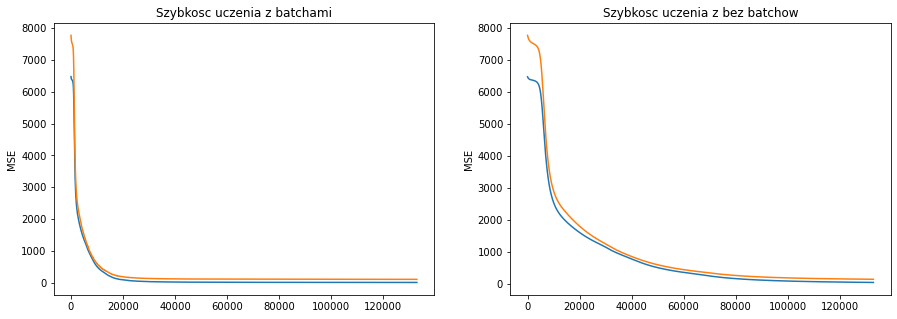

In [22]:
unnested_mse_train_list = list(chain.from_iterable(mse_train_list))
unnested_mse_test_list = list(chain.from_iterable(mse_test_list))
unnested_mse_train_list_nobatches = list(chain.from_iterable(mse_train_list_nobatches))
unnested_mse_test_list_nobatches = list(chain.from_iterable(mse_test_list_nobatches))


fig, axs = plt.subplots(1,2, figsize=(15, 5))

x1 = np.arange(0, len(unnested_mse_train_list))
axs[0].plot(x1, unnested_mse_train_list)
axs[0].plot(x1, unnested_mse_test_list)
axs[0].set_title('Szybkosc uczenia z batchami')
axs[0].set_ylabel('MSE')

x1 = np.arange(0, len(unnested_mse_train_list_nobatches))
axs[1].plot(x1, unnested_mse_train_list_nobatches)
axs[1].plot(x1, unnested_mse_test_list_nobatches)
axs[1].set_title('Szybkosc uczenia z bez batchow')
axs[1].set_ylabel('MSE')

plt.show()

## Zbiór multimodal-large

In [23]:
df_train = pd.read_csv('mio1/regression/multimodal-large-training.csv')
x_train, y_train = np.array(df_train['x']).reshape(-1,1), np.array(df_train['y']).reshape(-1,1)

df_test = pd.read_csv('mio1/regression/multimodal-large-test.csv')
x_test, y_test = np.array(df_test['x']).reshape(-1,1), np.array(df_test['y']).reshape(-1,1)

#### Wizualizacja zbioru

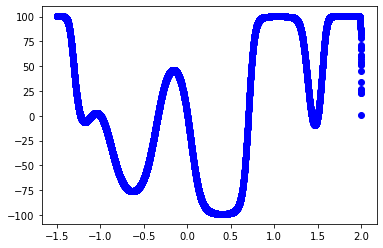

In [24]:
plt.plot(x_train, y_train, 'bo')

#### Trening sieci

In [25]:
np.random.seed(9)
mlp = MLP([1,10,10,10,1], sigmoid, sigmoid_derivative)

In [26]:
mse_train_list=[]
mse_test_list=[]

last_mse_test = np.inf

i=1
while last_mse_test>40:
    print(i)
    i+=1
    mse_train, mse_test = mlp.train(x_train, y_train, x_test, y_test, 100, 0.001, 50)
    print('Train MSE: ', mse_train[-1])
    print('Test MSE: ', mse_test[-1])
    mse_train_list.append(mse_train)
    mse_test_list.append(mse_test)
    last_mse_test=mse_test[-1]

1
Train MSE:  2506.381605742429
Test MSE:  2609.7621022644907
2
Train MSE:  1506.4055526640905
Test MSE:  1654.623229567891
3
Train MSE:  462.92307793092624
Test MSE:  504.4640486591562
4
Train MSE:  23.926378431849987
Test MSE:  17.867973493372933


Dopasowanie predykcji

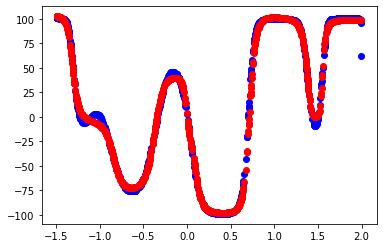

In [27]:
y_pred = mlp.predict(x_test)
plt.plot(x_test, y_test, 'bo')
plt.plot(x_test, y_pred, 'ro')

Wizualizacja zmiany wag

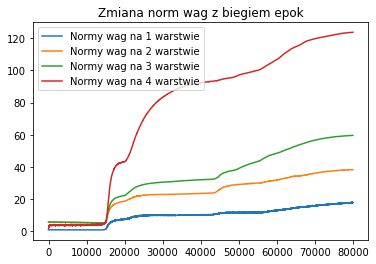

In [28]:
x = [i for i in range(1, 4*1000*20)]
w1 = [mlp.weights_norms[i][0] for i in range(len(x))]
w2 = [mlp.weights_norms[i][1] for i in range(len(x))]
w3 = [mlp.weights_norms[i][2] for i in range(len(x))]
w4 = [mlp.weights_norms[i][3] for i in range(len(x))]

fig, ax = plt.subplots()

ax.plot(x,w1, label='Normy wag na 1 warstwie')
ax.plot(x,w2, label='Normy wag na 2 warstwie')
ax.plot(x,w3, label='Normy wag na 3 warstwie')
ax.plot(x,w4, label='Normy wag na 4 warstwie')

ax.set_title('Zmiana norm wag z biegiem epok')
ax.legend()
plt.show()

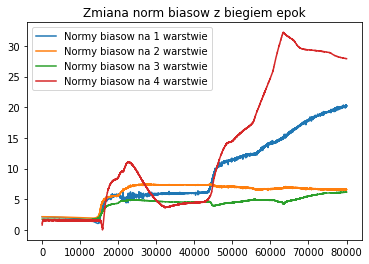

In [29]:
x = [i for i in range(1, 4*1000*20)]
b1 = [mlp.biases_norms[i][0] for i in range(len(x))]
b2 = [mlp.biases_norms[i][1] for i in range(len(x))]
b3 = [mlp.biases_norms[i][2] for i in range(len(x))]
b4 = [mlp.biases_norms[i][3] for i in range(len(x))]

fig, ax = plt.subplots()

ax.plot(x,b1, label='Normy biasow na 1 warstwie')
ax.plot(x,b2, label='Normy biasow na 2 warstwie')
ax.plot(x,b3, label='Normy biasow na 3 warstwie')
ax.plot(x,b4, label='Normy biasow na 4 warstwie')

ax.set_title('Zmiana norm biasow z biegiem epok')
ax.legend()
plt.show()

Bez batchow

In [30]:
np.random.seed(9)
mlp = MLP([1,10,10,10,1], sigmoid, sigmoid_derivative)

In [31]:
mse_train_list_nobatches=[]
mse_test_list_nobatches=[]

for i in range(4):
    print(i)
    mse_train, mse_test = mlp.train(x_train, y_train, x_test, y_test, 100, 0.001)
    print('Train MSE: ', mse_train[-1])
    print('Test MSE: ', mse_test[-1])
    mse_train_list_nobatches.append(mse_train)
    mse_test_list_nobatches.append(mse_test)

0
Train MSE:  5185.438334887474
Test MSE:  5231.1018891141075
1
Train MSE:  5178.117835136117
Test MSE:  5222.751722328196
2
Train MSE:  5177.298466717551
Test MSE:  5221.587950020988
3
Train MSE:  5177.20631750226
Test MSE:  5221.380631967138


Porownanie szybkosci uczenia

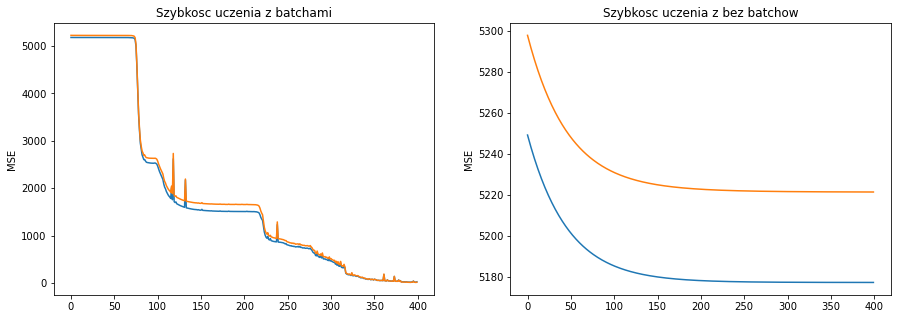

In [32]:
unnested_mse_train_list = list(chain.from_iterable(mse_train_list))
unnested_mse_test_list = list(chain.from_iterable(mse_test_list))
unnested_mse_train_list_nobatches = list(chain.from_iterable(mse_train_list_nobatches))
unnested_mse_test_list_nobatches = list(chain.from_iterable(mse_test_list_nobatches))


fig, axs = plt.subplots(1,2, figsize=(15, 5))

x1 = np.arange(0, len(unnested_mse_train_list))
axs[0].plot(x1, unnested_mse_train_list)
axs[0].plot(x1, unnested_mse_test_list)
axs[0].set_title('Szybkosc uczenia z batchami')
axs[0].set_ylabel('MSE')

x1 = np.arange(0, len(unnested_mse_train_list_nobatches))
axs[1].plot(x1, unnested_mse_train_list_nobatches)
axs[1].plot(x1, unnested_mse_test_list_nobatches)
axs[1].set_title('Szybkosc uczenia z bez batchow')
axs[1].set_ylabel('MSE')

plt.show()